In [35]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
df = pd.read_hdf('../data/processed/bexar_processed.h5')

In [3]:
# Trim out those same price psf outlier properties
trim_prop_df = df[df.price_psf<df.price_psf.quantile(.999)]
trim_prop_df.shape

(554697, 78)

In [6]:
# Grab all columns that are under the 70,000 nan limit
nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop([
    'prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
    'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
    'bexar_2017_market_value','bexar_2018_market_value','owner_zip_code',
    'property_zip','neighborhood_code'
])

sub_df = trim_prop_df[variables_list]
sub_df = sub_df.dropna()

In [7]:
X = sub_df.iloc[:,:-1]
y = sub_df.crim_prop

In [8]:
X.dtypes

partial_owner                 int64
py_confidential_flag          int64
py_address_suppress_flag      int64
py_addr_ml_deliverable        int64
land_acres                    int64
market_value                  int64
appr_confidential_flag        int64
Yr_blt                        int64
Sq_ft                         int64
just_established_owner        int64
foreign_based_owner           int64
yoy_diff_2019               float64
yoy_diff_2018               float64
yoy_diff_2017               float64
yoy_diff_2016               float64
out_of_state_owner            int64
entity_agent_binary           int64
owner_legal_person            int64
owner_likely_company          int64
owner_is_trust                int64
sos_status_code__A            uint8
sos_status_code__C            uint8
sos_status_code__F            uint8
sos_status_code__R            uint8
sos_status_code__Y            uint8
owner_owns_multiple           int64
price_psf                   float64
two_gto_reqs                

In [9]:
X_norm = normalize(X)

In [10]:
X_pca = PCA(2).fit_transform(X_norm)

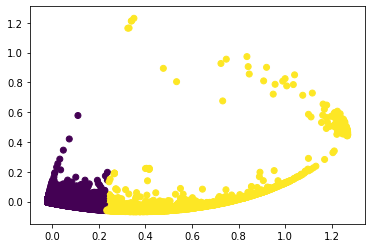

Comparing k-means clusters against the data:
crim_prop     0.0  1.0
row_0                 
0          526114   33
1            4762    0


In [11]:
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Employing the elbow method may reveal the optimal number of clusters. Distortion will decrease as k increases, so identifying the value of k where the distortion begins to increase most rapidly will allow for an estimation of the optimal k.

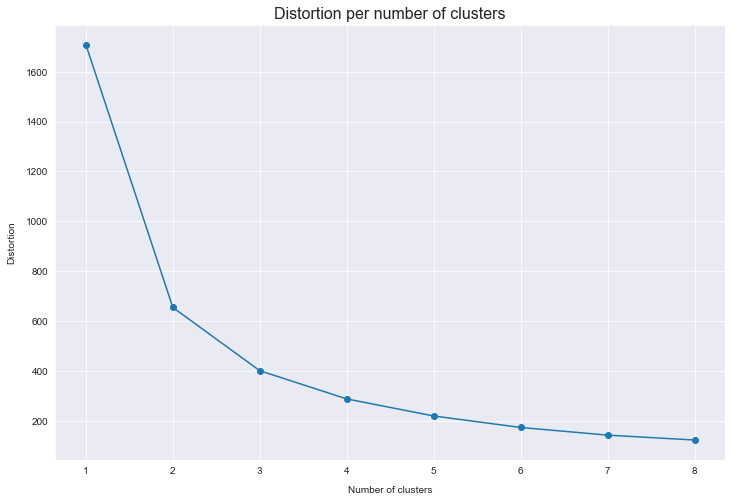

In [23]:
skip = 0
if skip == 0:
    distortions = []
    for i in range(1, 9):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    random_state=3)
        km.fit(X_norm)
        distortions.append(km.inertia_)
        
    plt.figure(figsize=(12,8))
    plt.plot(range(1, 9), distortions, marker='o')
    plt.xlabel('Number of clusters',labelpad=10)
    plt.ylabel('Distortion',labelpad=10)
    plt.title('Distortion per number of clusters',fontsize=16)
    plt.show()

It would appear the k=2 or k=3 are the optimal number of clusters.

In [27]:
X_norm.shape

(530909, 28)

In [38]:
X_norm_df = pd.DataFrame(data=X_norm)
X_norm_sample = X_norm_df.sample(frac=0.1)
X_norm_sample.shape

(53091, 28)

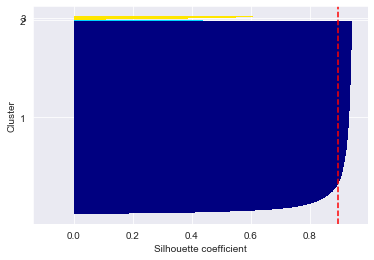

In [42]:
skip = 0
if skip == 0:
    km = KMeans(n_clusters=3,
                init='k-means++',
                random_state=3)
    y_km = km.fit_predict(X_norm_sample)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X_norm_sample, y_km, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                 c_silhouette_vals,
                 height=1.0,
                 edgecolor='none',
                 color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color='red',
                linestyle='--')
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

In [44]:
km = KMeans(
    n_clusters=3,
    init='k-means++',
    max_iter=300,
    random_state=42
       )
y_km = km.fit_predict(X_norm_sample)